In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget
# %matplotlib inline

# Parse measurements from file

TIME_DIVISION = 100

times = np.arange(1024)*TIME_DIVISION

def readFile(filename):

    data = {"ch0": [], "ch1": [], "ch3": []}

    with open(filename) as file:

        # skip file header
        file.readline()
        file.readline()
        file.readline()
        file.readline()

        while True:

            # skip event header and check end of file
            if not file.readline(): break
            file.readline()

            # skip channel 0 header
            file.readline()

            ch0_vals = file.readline()
            ch0_vals = list(map(lambda x: -float(x), ch0_vals.split()))
            data["ch0"].append(np.array(ch0_vals))

            # skip channel 1 header
            file.readline()

            ch1_vals = file.readline()
            ch1_vals = list(map(lambda x: -float(x), ch1_vals.split()))
            data["ch1"].append(np.array(ch1_vals))

            # skip channel 2 header
            file.readline()

            ch3_vals = file.readline()
            ch3_vals = list(map(lambda x: -float(x), ch3_vals.split()))
            data["ch3"].append(np.array(ch3_vals))

    data["ch0"] = np.array(data["ch0"])
    data["ch1"] = np.array(data["ch1"])
    data["ch3"] = np.array(data["ch3"])

    return data

data = readFile("Data_received/New_measurements/Plate/Run_WFs_PMT+plate_100 mks_10K evts_4_1_2025_Ascii.dat")

In [1]:
# start index
data["st_idx"] = np.empty(data["ch0"].shape[0], dtype=int)

for i in range(data["ch0"].shape[0]):

    max_val = np.max(data["ch0"][i])

    start_idx = np.argmax(data["ch0"][i] >= 0.5*max_val)
    
    # sometimes we have two synchro peacks, the correct one is first and low in y scale
    # this if branch of code to account for that effect
    if start_idx > 100:
        
        start_idx = np.argmax(data["ch0"][i] >= 0.03)


    data["st_idx"][i] = start_idx

min_st_idx = int(np.min(data["st_idx"]))
max_st_idx = int(np.max(data["st_idx"]))

data_shifted = {}
data_shifted["ch0"] = np.empty([ data["ch0"].shape[0], data["ch0"].shape[1] - (max_st_idx-min_st_idx) ])
data_shifted["ch1"] = np.empty([ data["ch1"].shape[0], data["ch1"].shape[1] - (max_st_idx-min_st_idx) ])
data_shifted["ch3"] = np.empty([ data["ch3"].shape[0], data["ch3"].shape[1] - (max_st_idx-min_st_idx) ])


for i in range(data["ch0"].shape[0]):

    stIdx = data["st_idx"][i]

    start_idx = stIdx-min_st_idx
    stop_ind  = data["ch0"][i].size -(max_st_idx-stIdx)

    data_shifted["ch0"][i] = data["ch0"][i, start_idx: stop_ind]
    data_shifted["ch1"][i] = data["ch1"][i, start_idx: stop_ind]
    data_shifted["ch3"][i] = data["ch3"][i, start_idx: stop_ind]

NameError: name 'np' is not defined

In [ ]:

# plt.figure()

# for i in range(10):

#     plt.plot(times, data["ch0"][i,:])

# plt.figure()
# for i in range(10):

#     plt.plot(times, data["ch3"][i,:])

min_st_idx = 26
max_st_idx = 55


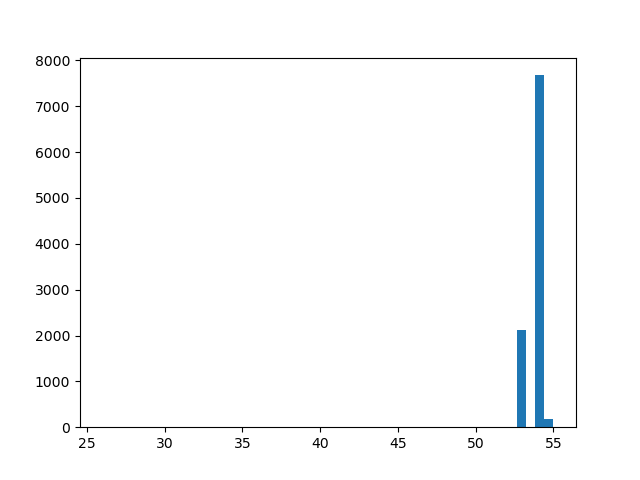

In [ ]:
plt.figure()

print("min_st_idx =", min_st_idx)
print("max_st_idx =", max_st_idx)

plt.hist(data["st_idx"], bins = 50);

In [ ]:
miss = np.abs( data["st_idx"] - np.mean(data["st_idx"]) ) < 3*np.std(data["st_idx"])

print("Total number of misses", np.sum(miss))

miss_idx = list(np.nonzero(miss)[0])


# for i in miss_idx:

#     plt.figure()

#     plt.subplot(2,1,1)
#     plt.plot(times, data["ch0"][i])

#     plt.subplot(2,1,2)
#     plt.plot(times, data["ch3"][i])

#     plt.show()


Total number of misses 9983


Text(0.5, 0, 'time [ns]')

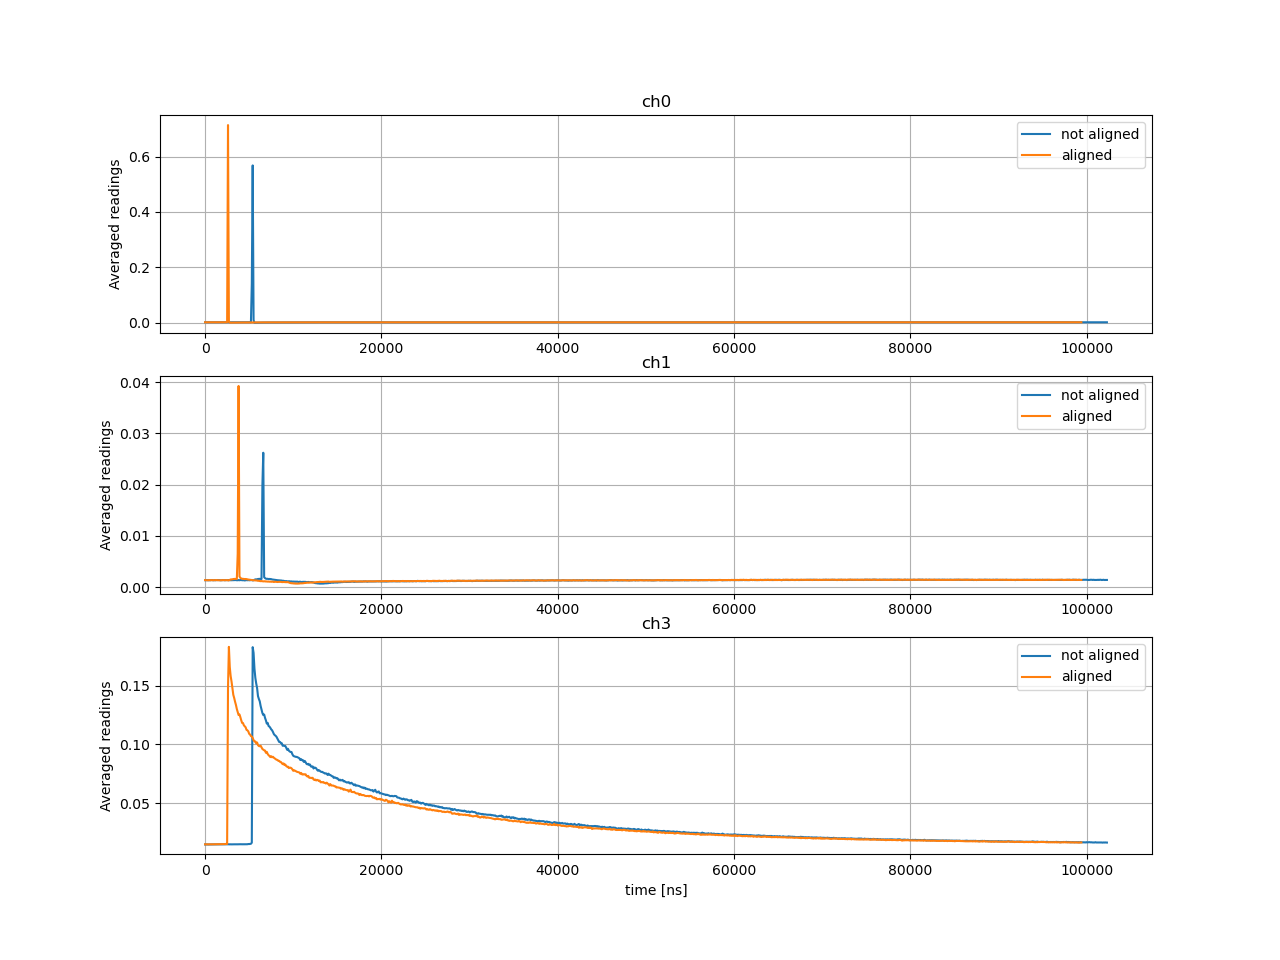

In [ ]:
plt.figure(figsize=(6.4*2, 4.8*2))

plt.subplot(3,1,1)
plt.plot(times, np.mean(data["ch0"], axis=0), label="not aligned")
plt.plot(times[:-(max_st_idx-min_st_idx)], np.mean(data_shifted["ch0"], axis=0), label="aligned")
plt.title("ch0")
plt.legend()
plt.grid()
plt.ylabel("Averaged readings")


plt.subplot(3,1,2)
plt.plot(times, np.mean(data["ch1"], axis=0), label="not aligned")
plt.plot(times[:-(max_st_idx-min_st_idx)], np.mean(data_shifted["ch1"], axis=0), label="aligned")
plt.title("ch1")
plt.legend()
plt.grid()
plt.ylabel("Averaged readings")

plt.subplot(3,1,3)
plt.plot(times, np.mean(data["ch3"], axis=0), label="not aligned")
plt.plot(times[:-(max_st_idx-min_st_idx)], np.mean(data_shifted["ch3"], axis=0), label="aligned")
plt.title("ch3")
plt.legend()
plt.grid()
plt.ylabel("Averaged readings")

plt.xlabel("time [ns]")

In [ ]:
av_readings = np.mean(data_shifted["ch3"], axis=0)
av_times = times[:-(max_st_idx-min_st_idx)]

START_TIME = 2700 # ns
START_INDEX = int(np.argmax(times > START_TIME))

In [ ]:
from scipy.optimize import curve_fit

def fitFunc(t, A0, A1, A2, A3, A4, L1, L2, L3, L4):

    return A0 + A1*np.exp(-L1*t) + A2*np.exp(-L2*t) + A3*np.exp(-L3*t) + A4*np.exp(-L4*t)

def get_fit_params(tiumes_arg, sig):

    A0 = 0.0962
    A1 = 0.0060
    A2 = 0.0210
    A3 = 0.0300
    A4 = 0.0336
    L1 = 1/1329.9464
    L2 = 1/1329.5913
    L3 = 1/168.2501    
    L4 = 1/43.6947   


    pars = [A0, A1, A2, A3, A4, L1, L2, L3, L4]

    bounds = (
        #    A0,     A1,     A2,     A3,     A4,     L1,     L2,     L3,     L4
        (     0,      0,      0,      0,      0,      0,      0,      0,      0),
        (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf) 
    )

    popt, pcov = curve_fit(fitFunc, tiumes_arg, sig, p0=pars, bounds=bounds, maxfev=50000)

    A0, A1, A2, A3, A4, L1, L2, L3, L4 = popt

    result = {
        "A0": A0,
        "A1": A1,
        "A2": A2,
        "A3": A3,
        "A4": A4,
        "L1": L1,
        "L2": L2,
        "L3": L3,
        "L4": L4,
        }
    
    return result, pcov

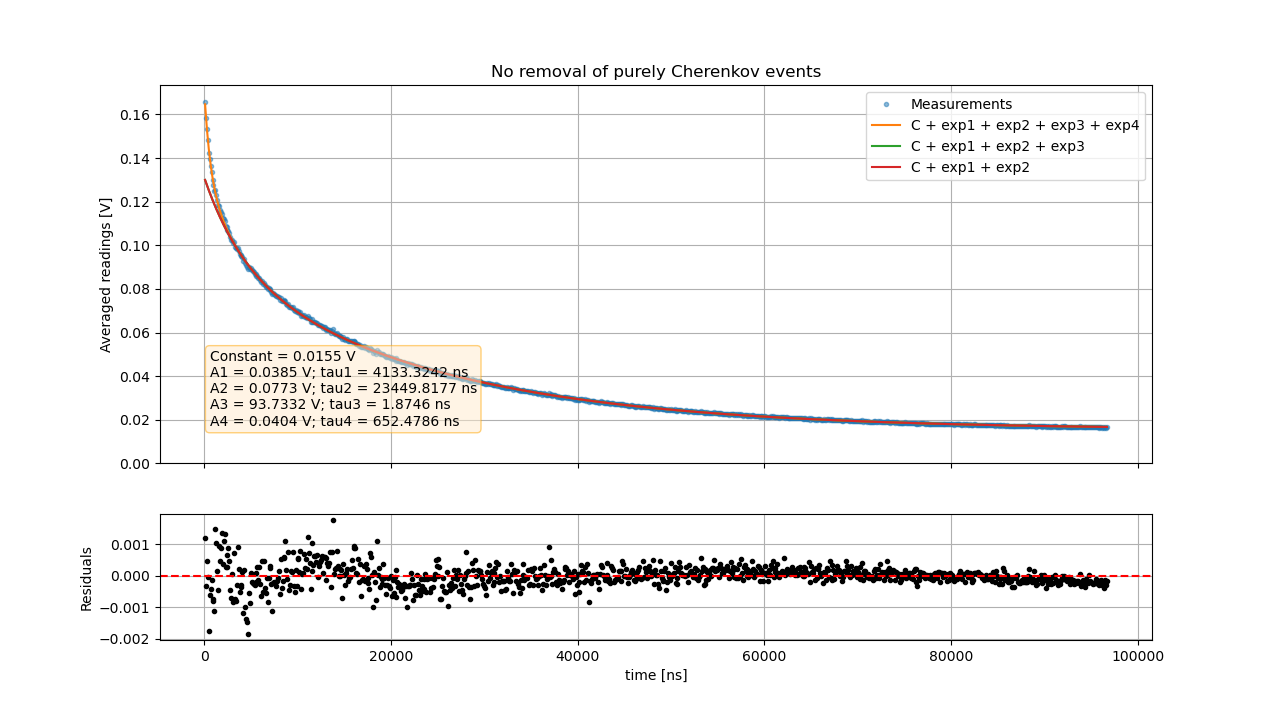

In [ ]:
fig,(axm, axe) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6.4*2,4.8*1.5))

time_plot = av_times[START_INDEX:] - START_TIME
read_plot = av_readings[START_INDEX:]

#############################################
## Perform fitting and draw it on the plot ##
#############################################

fit_params, pconv = get_fit_params(time_plot, read_plot)

axm.plot(time_plot, read_plot, ".", label = "Measurements", alpha = 0.5)

axm.plot(time_plot, fitFunc(time_plot, **fit_params), label = "C + exp1 + exp2 + exp3 + exp4")

A0, A1, A2, A3, A4, L1, L2, L3, L4 = fit_params.values()

exp123 = lambda t: A0 + A1*np.exp(-L1*t) + A2*np.exp(-L2*t) + A3*np.exp(-L3*t)
axm.plot(time_plot, exp123(time_plot), label="C + exp1 + exp2 + exp3")

exp1 = lambda t: A0 + A1*np.exp(-L1*t) + A2*np.exp(-L2*t)
axm.plot(time_plot, exp1(time_plot), label="C + exp1 + exp2")


axm.set_ylabel("Averaged readings [V]")
axm.set_ylim(0, None)
axm.grid()
axm.legend()
axm.set_title("No removal of purely Cherenkov events")


bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
axm.text( 0.05, 0.1,
         "Constant = {:.4f} V\n".format(fit_params["A0"])+\
         "A1 = {:.4f} V; tau1 = {:.4f} ns\n".format(fit_params["A1"], 1/fit_params["L1"])+\
         "A2 = {:.4f} V; tau2 = {:.4f} ns\n".format(fit_params["A2"], 1/fit_params["L2"])+\
         "A3 = {:.4f} V; tau3 = {:.4f} ns\n".format(fit_params["A3"], 1/fit_params["L3"])+\
         "A4 = {:.4f} V; tau4 = {:.4f} ns  ".format(fit_params["A4"], 1/fit_params["L4"]),      
         transform = axm.transAxes, bbox=bbox)


#########################################################
## Perform estimation and draw of the uncertainty bars ##
#########################################################

# # Compute uncertainty in fit
# num_samples = 10000  # Number of Monte Carlo samples for uncertainty estimation
# param_samples = np.random.multivariate_normal(list(fit_params.values()), pconv, size=num_samples)

# y_fits = np.array([fitFunc(time_plot, *p) for p in param_samples])
# y_fit_mean = np.mean(y_fits, axis=0)
# y_fit_std = np.std(y_fits, axis=0)

residuals = read_plot - fitFunc(time_plot, **fit_params)

# Plot the residuals with error bars
axe.plot(time_plot, residuals, ".k")
axe.axhline(0, color="red", linestyle="--")
# axe.fill_between(time_plot, -2 * y_fit_std, 2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

# axm.fill_between(time_plot, y_fit_mean-2 * y_fit_std, y_fit_mean+2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

axe.set_ylabel("Residuals")
axe.set_xlabel("time [ns]")
# axe.legend()
axe.grid()


## Charge intergall calculations

2.9491511706240006e-09


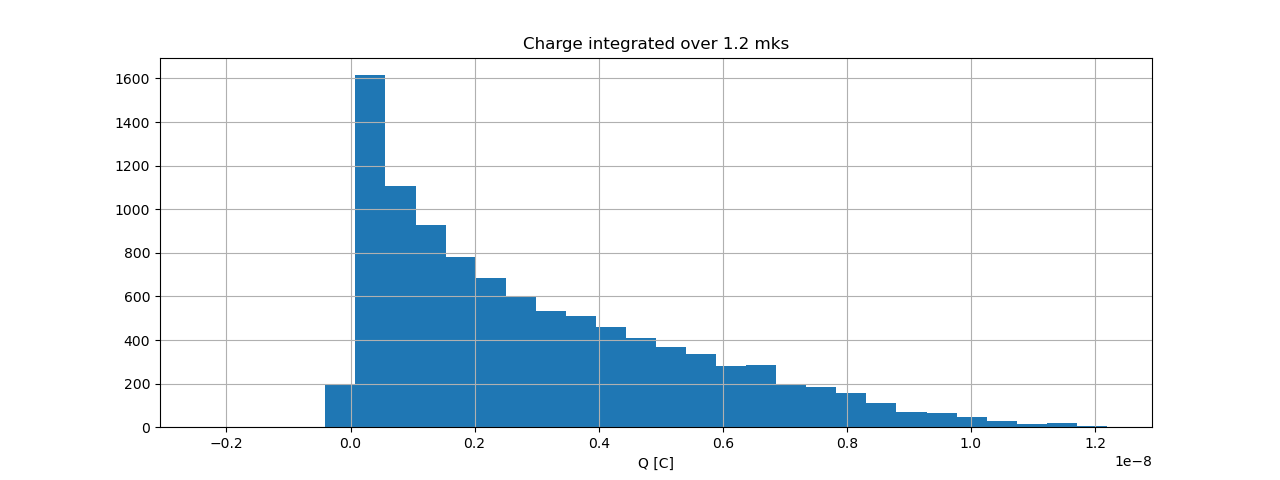

In [ ]:
resistance = 50 # ohm
st_idx = int(np.floor(2500/TIME_DIVISION))
md_idx = st_idx + int(np.floor(200/TIME_DIVISION))
ed_idx = st_idx + int(np.floor(1200/TIME_DIVISION))

data_shifted["Qc_arr"] = np.empty(data_shifted["ch3"].shape[0])
data_shifted["Qs_arr"] = np.empty(data_shifted["ch3"].shape[0])

for i in range(data_shifted["ch3"].shape[0]):

    bkg = np.mean(data_shifted["ch3"][i, :st_idx])

    Qc = (data_shifted["ch3"][i, st_idx:md_idx] - bkg)/resistance 
    Qc = np.sum(Qc)*TIME_DIVISION*1e-9
    data_shifted["Qc_arr"][i] = Qc

    Qs = (data_shifted["ch3"][i, md_idx:ed_idx] - bkg)/resistance
    Qs = np.sum(Qs)*TIME_DIVISION*1e-9
    data_shifted["Qs_arr"][i] = Qs
    

plt.figure(figsize=(6.4*2, 4.8))
plt.hist(data_shifted["Qc_arr"]+data_shifted["Qs_arr"], bins=30)
plt.title("Charge integrated over 1.2 mks")
plt.xlabel("Q [C]")
plt.grid()

print(np.mean(data_shifted["Qc_arr"]+data_shifted["Qs_arr"]))

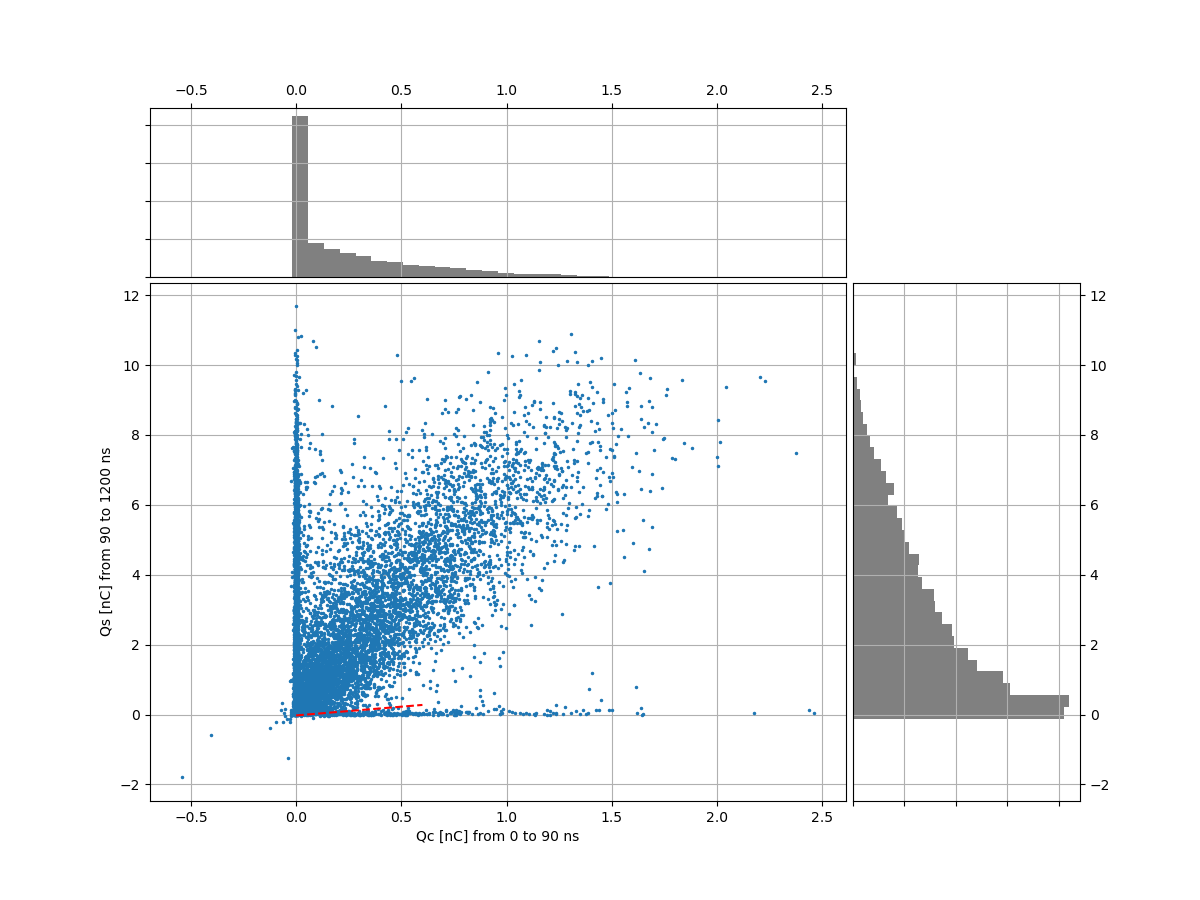

In [ ]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(12, 9))
grid = plt.GridSpec(4, 4, hspace=0.03, wspace=0.03)
main_ax = fig.add_subplot(grid[1:, :-1])
y_hist = fig.add_subplot(grid[1:, -1], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[0, :-1], yticklabels=[], sharex=main_ax)
 
# scatter points on the main axes
main_ax.plot(data_shifted["Qc_arr"]/1e-9, data_shifted["Qs_arr"]/1e-9, ".", markersize=3,)
main_ax.set_xlabel("Qc [nC] from 0 to 90 ns")
main_ax.set_ylabel("Qs [nC] from 90 to 1200 ns")
main_ax.grid()

# histogram on the attached axes
x_hist.hist(data_shifted["Qc_arr"]/1e-9, 40, histtype='stepfilled',
        orientation='vertical', color='gray')
x_hist.xaxis.set_label_position('top')
x_hist.xaxis.tick_top()
x_hist.grid()

y_hist.hist(data_shifted["Qs_arr"]/1e-9, 40, histtype='stepfilled',
        orientation='horizontal', color='gray')
y_hist.yaxis.set_label_position('right')
y_hist.yaxis.tick_right()
y_hist.grid()


discrimination_curve = lambda x: 0.50*(x-0.05)
disc_x_c = np.array([0, 0.6])
disc_y_c = discrimination_curve(disc_x_c)
main_ax.plot(disc_x_c, disc_y_c, "--r")

In [ ]:
acceptedEvents = data_shifted["Qs_arr"]/1e-9 > discrimination_curve(data_shifted["Qc_arr"]/1e-9)

av_readings_nc = np.mean(data_shifted["ch3"][acceptedEvents], axis=0)
av_times_nc = times[:-(max_st_idx-min_st_idx)]

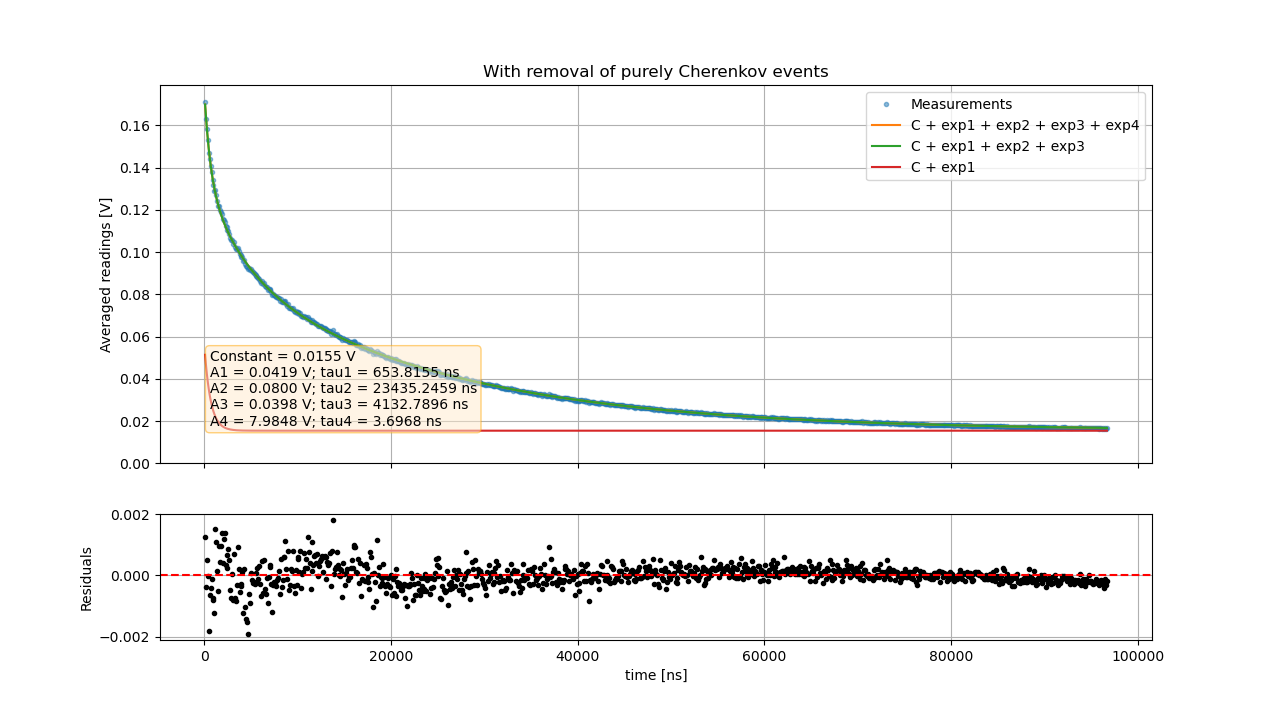

In [ ]:
fig,(axm, axe) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6.4*2,4.8*1.5))

time_plot = av_times_nc[START_INDEX:] - START_TIME
read_plot = av_readings_nc[START_INDEX:]

#############################################
## Perform fitting and draw it on the plot ##
#############################################

fit_params, pconv = get_fit_params(time_plot, read_plot)

axm.plot(time_plot, read_plot, ".", label = "Measurements", alpha = 0.5)

axm.plot(time_plot, fitFunc(time_plot, **fit_params), label = "C + exp1 + exp2 + exp3 + exp4")

A0, A1, A2, A3, A4, L1, L2, L3, L4 = fit_params.values()

exp123 = lambda t: A0 + A1*np.exp(-L1*t) + A2*np.exp(-L2*t) + A3*np.exp(-L3*t)
axm.plot(time_plot, exp123(time_plot), label="C + exp1 + exp2 + exp3")

exp1 = lambda t: A0 + A1*np.exp(-L1*t)
axm.plot(time_plot, exp1(time_plot), label="C + exp1")


axm.set_ylabel("Averaged readings [V]")
axm.set_ylim(0, None)
axm.grid()
axm.legend()
axm.set_title("With removal of purely Cherenkov events")


bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
axm.text( 0.05, 0.1,
         "Constant = {:.4f} V\n".format(fit_params["A0"])+\
         "A1 = {:.4f} V; tau1 = {:.4f} ns\n".format(fit_params["A1"], 1/fit_params["L1"])+\
         "A2 = {:.4f} V; tau2 = {:.4f} ns\n".format(fit_params["A2"], 1/fit_params["L2"])+\
         "A3 = {:.4f} V; tau3 = {:.4f} ns\n".format(fit_params["A3"], 1/fit_params["L3"])+\
         "A4 = {:.4f} V; tau4 = {:.4f} ns  ".format(fit_params["A4"], 1/fit_params["L4"]),      
         transform = axm.transAxes, bbox=bbox)


#########################################################
## Perform estimation and draw of the uncertainty bars ##
#########################################################

# # Compute uncertainty in fit
# num_samples = 10000  # Number of Monte Carlo samples for uncertainty estimation
# param_samples = np.random.multivariate_normal(list(fit_params.values()), pconv, size=num_samples)

# y_fits = np.array([fitFunc(time_plot, *p) for p in param_samples])
# y_fit_mean = np.mean(y_fits, axis=0)
# y_fit_std = np.std(y_fits, axis=0)

residuals = read_plot - fitFunc(time_plot, **fit_params)

# Plot the residuals with error bars
axe.plot(time_plot, residuals, ".k")
axe.axhline(0, color="red", linestyle="--")
# axe.fill_between(time_plot, -2 * y_fit_std, 2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

# axm.fill_between(time_plot, y_fit_mean-2 * y_fit_std, y_fit_mean+2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

axe.set_ylabel("Residuals")
axe.set_xlabel("time [ns]")
# axe.legend()
axe.grid()
